In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
!pip install -U scikit-learn==1.4.2 imbalanced-learn==0.12.3
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 101.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 14.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.


In [2]:
import sklearn, imblearn, numpy
print("sklearn:", sklearn.__version__)
print("imblearn:", imblearn.__version__)
print("numpy:", numpy.__version__)

sklearn: 1.4.2
imblearn: 0.12.3
numpy: 1.26.4


## Prediction for Teleco Customer Churn

**Goal:**
Build a predictive model to identify customers at a risk of churn and highlight key factors driving their decisions.
This project demonstrates data preprocessing, feature engineering, handling class imbalance,and baseline machine learning models (Logistic Regression, Random Forest, XGBoost).

**Business Context:**
Predicting customer churn is critical for the subscription-based business model. By identifying those customers in advance, company can design targeted retention strategies and reduce revenue loss.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Data Processing & EDA

In [4]:
df = pd.read_csv("/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv")

print(df.shape)
print(df.columns)
print(df["Churn"].value_counts(normalize=True))

(7043, 21)
Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')
Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64


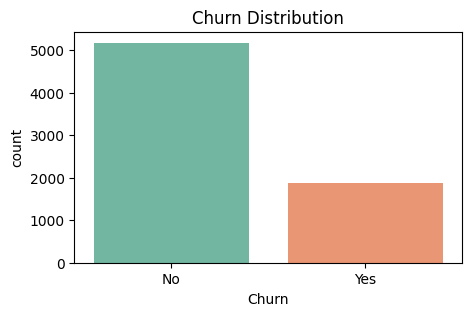

In [5]:
plt.figure(figsize=(5,3))

sns.countplot(x="Churn", data=df, palette="Set2")

plt.title("Churn Distribution")
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

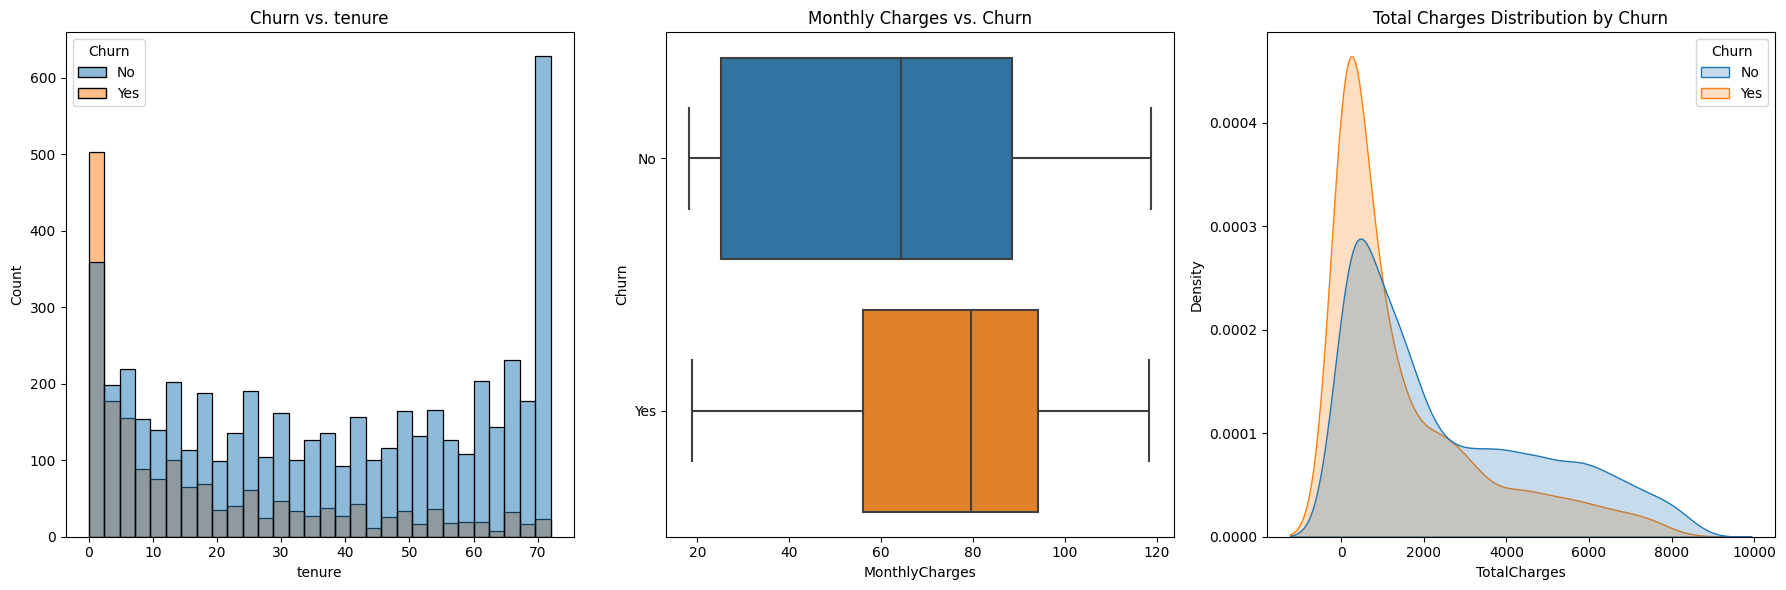

In [6]:
df["TotalCharges"] = pd.to_numeric(df['TotalCharges'], errors='coerce')

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
sns.histplot(data=df, x="tenure", hue="Churn", bins=30, kde=False, ax=axs[0])
axs[0].set_title("Churn vs. tenure")

sns.boxplot(data=df, x='MonthlyCharges', y='Churn', ax=axs[1])
axs[1].set_title("Monthly Charges vs. Churn")

sns.kdeplot(data=df, x='TotalCharges', hue='Churn', common_norm=False, fill=True, ax=axs[2])
axs[2].set_title("Total Charges Distribution by Churn")

plt.tight_layout()
plt.show()

### Feature Engineering

In [7]:
# print(df.head())
df = df.drop('customerID', axis=1)
df['Churn'] = df['Churn'].map({"Yes": 1, "No": 0})

df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

df = pd.get_dummies(df, drop_first=True)

# print(df.head())

### Baseline Model: Logistic Regression

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X = df.drop('Churn', axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(X_train.shape, X_test.shape)

(5634, 30) (1409, 30)


In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.pipeline import Pipeline

logreg_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000, random_state=42))
])

logreg_pipe.fit(X_train, y_train)

y_pred = logreg_pipe.predict(X_test)
cm1 = confusion_matrix(y_test, y_pred)
print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))
print("\nConfusion Matrix:\n", cm1)

Classification Report:
               precision    recall  f1-score   support

           0     0.8510    0.8937    0.8718      1035
           1     0.6584    0.5668    0.6092       374

    accuracy                         0.8070      1409
   macro avg     0.7547    0.7303    0.7405      1409
weighted avg     0.7998    0.8070    0.8021      1409


Confusion Matrix:
 [[925 110]
 [162 212]]


In [10]:
# To improve "recall", tried "class_weight" as "balanced".

logreg_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42))
])

logreg_pipe.fit(X_train, y_train)

y_pred = logreg_pipe.predict(X_test)
cm2 = confusion_matrix(y_test, y_pred)
print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))
print("\nConfusion Matrix:\n", cm2)

Classification Report:
               precision    recall  f1-score   support

           0     0.9013    0.7237    0.8028      1035
           1     0.5052    0.7807    0.6134       374

    accuracy                         0.7388      1409
   macro avg     0.7033    0.7522    0.7081      1409
weighted avg     0.7962    0.7388    0.7525      1409


Confusion Matrix:
 [[749 286]
 [ 82 292]]


In [11]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(k_neighbors=5, random_state=42)
X_tr_res, y_tr_res = sm.fit_resample(X_train, y_train)

logreg_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000, random_state=42))
])

logreg_pipe.fit(X_tr_res, y_tr_res)
y_pred = logreg_pipe.predict(X_test)
cm3 = confusion_matrix(y_test, y_pred)

print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))
print("Confusion Matrix:\n", cm3)


Classification Report:
               precision    recall  f1-score   support

           0     0.8573    0.8068    0.8313      1035
           1     0.5402    0.6283    0.5810       374

    accuracy                         0.7594      1409
   macro avg     0.6988    0.7176    0.7061      1409
weighted avg     0.7731    0.7594    0.7648      1409

Confusion Matrix:
 [[835 200]
 [139 235]]


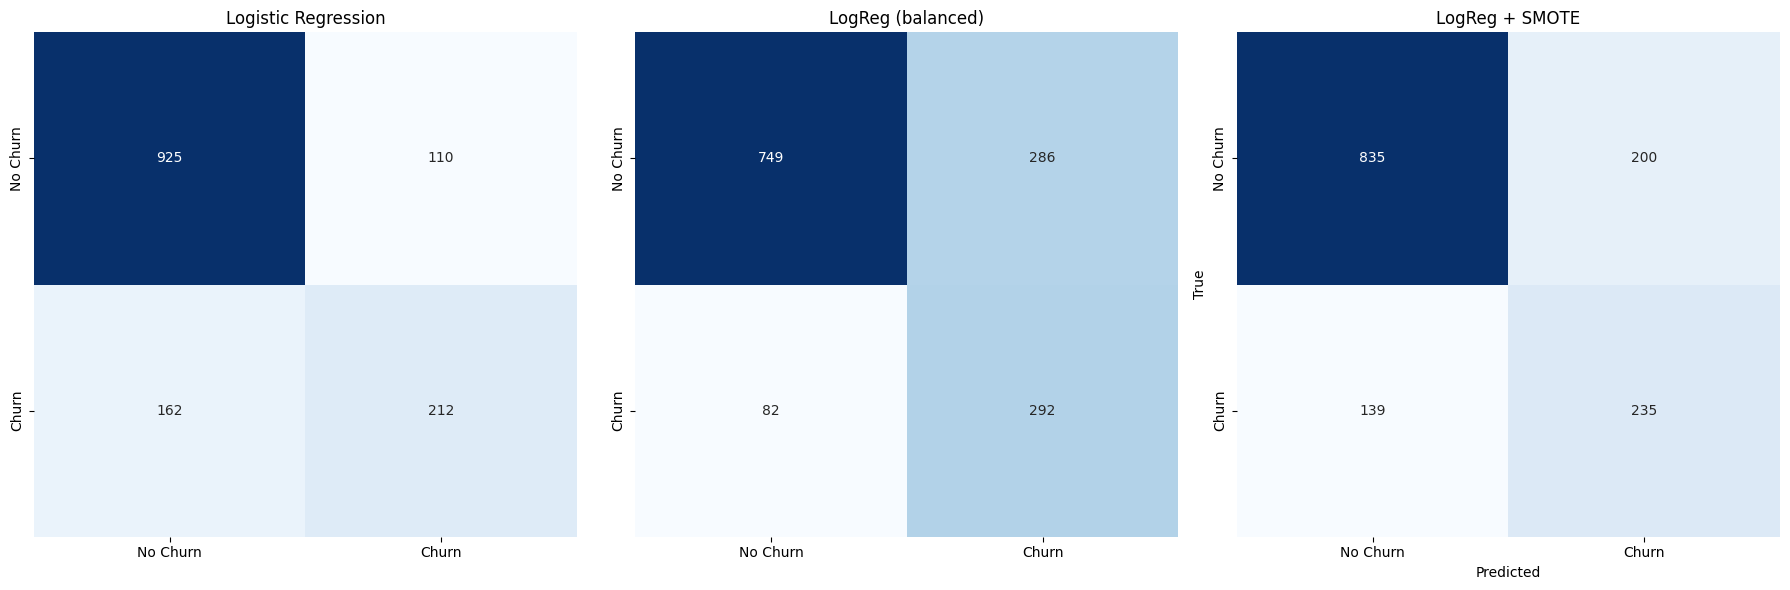

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
sns.heatmap(cm1, annot=True, fmt="d", cmap="Blues", cbar=False,
           xticklabels=["No Churn","Churn"], yticklabels=["No Churn","Churn"], ax=axs[0])
sns.heatmap(cm2, annot=True, fmt="d", cmap="Blues", cbar=False,
           xticklabels=["No Churn","Churn"], yticklabels=["No Churn","Churn"], ax=axs[1])
sns.heatmap(cm3, annot=True, fmt="d", cmap="Blues", cbar=False,
           xticklabels=["No Churn","Churn"], yticklabels=["No Churn","Churn"], ax=axs[2])
axs[0].set_title("Logistic Regression")
axs[1].set_title("LogReg (balanced)")
axs[2].set_title("LogReg + SMOTE")

plt.ylabel("True"); plt.xlabel("Predicted")
plt.tight_layout()
# plt.savefig("images/LogReg_confusion_matrices.png")
plt.show()

#### *Evaluation Function*

In [13]:
import os
os.makedirs("images", exist_ok=True)

In [14]:
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, 
                            precision_recall_fscore_support, roc_auc_score)
from sklearn.base import clone
import numpy as np

def evaluate_model(model, name, X_train, X_test, y_train, y_test, plot_cm=False):
    
    estimate = clone(model)
    estimate.fit(X_train, y_train)
    y_pred = estimate.predict(X_test)

    try:
        y_score = estimate.predict_prob(X_test)[:, 1] # get only churn
        auc = roc_auc_score(y_test, y_score)
    except:
        y_score = None
        auc = None

    acc = accuracy_score(y_test, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary")

    print(f"{name} Results:\n")
    print(f"\n[{name}] Acc={acc:.4f}  Prec={prec:.4f}  Rec={rec:.4f}  F1={f1:.4f}", (f"  ROC-AUC={auc:.4f}" if auc is not None else ""))

    print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))

    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:\n", cm)


    if plot_cm:
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                   xticklabels=["No Churn","Churn"], yticklabels=["No Churn","Churn"])
        plt.title(f"{name} - Confusion Matrix Plot")
        plt.ylabel("True"); plt.xlabel("Predicted")
        plt.tight_layout()
        plt.savefig(f"images/{name}_confusion_matrices.png")
        plt.show()

    return

### XGBoost & RandomForest

In [15]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

pos = y_train.sum()
neg = len(y_train) - pos
scale_pos = neg / pos if pos > 0 else 1.0  # For XGBoost

def build_xgb():
    return XGBClassifier(
        n_estimators=500,
        max_depth=5,
        learning_rate=0.08,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        objective="binary:logistic",
        n_jobs=-1,
        random_state=42,
        tree_method="gpu_hist",
        eval_metric="logloss",
        scale_pos_weight=scale_pos
    )

def build_rf():
    return RandomForestClassifier(
        n_estimators=400,
        max_depth=None,
        min_samples_split=4,
        min_samples_leaf=2,
        max_features="sqrt",
        class_weight="balanced_subsample",
        n_jobs=-1,
        random_state=42
    )

#### *Run Model*

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [21:28:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


XGBoost Results:


[XGBoost] Acc=0.7615  Prec=0.5397  Rec=0.6898  F1=0.6056 

Classification Report:
               precision    recall  f1-score   support

           0     0.8754    0.7874    0.8291      1035
           1     0.5397    0.6898    0.6056       374

    accuracy                         0.7615      1409
   macro avg     0.7076    0.7386    0.7174      1409
weighted avg     0.7863    0.7615    0.7698      1409


Confusion Matrix:
 [[815 220]
 [116 258]]


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [21:28:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [21:28:16] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


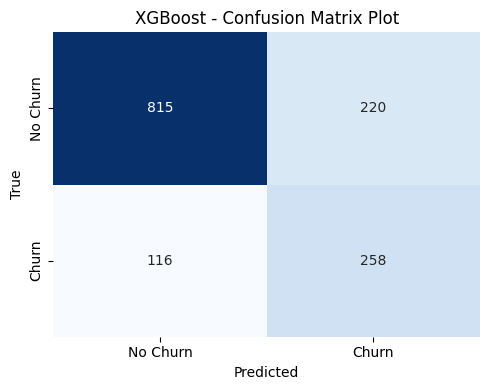

RandomForest Results:


[RandomForest] Acc=0.7800  Prec=0.5755  Rec=0.6524  F1=0.6115 

Classification Report:
               precision    recall  f1-score   support

           0     0.8680    0.8261    0.8465      1035
           1     0.5755    0.6524    0.6115       374

    accuracy                         0.7800      1409
   macro avg     0.7217    0.7392    0.7290      1409
weighted avg     0.7904    0.7800    0.7842      1409


Confusion Matrix:
 [[855 180]
 [130 244]]


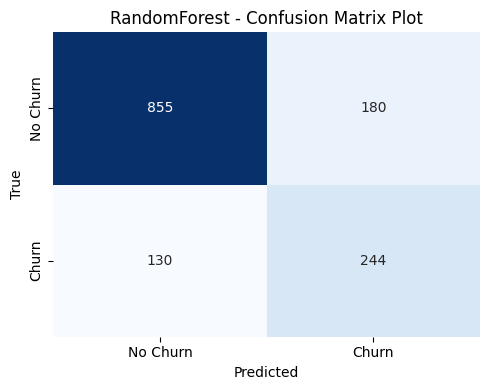

In [16]:
xgb = build_xgb()
rf  = build_rf()

_ = evaluate_model(xgb, "XGBoost", X_train, X_test, y_train, y_test, plot_cm=True)
_ = evaluate_model(rf,  "RandomForest", X_train, X_test, y_train, y_test, plot_cm=True)